# SMS Spam Collection Dataset
[![image](https://storage.googleapis.com/kaggle-datasets-images/483/982/15b24a8964e8d4afadff79a1a5543450/dataset-cover.jpg)](image)

> Collection of SMS messages tagged as spam or legitimate

> [Kaggle Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)


# Import Module

In [ ]:
import time
import torch
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split

In [ ]:
! pip install --upgrade kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.5
    Uninstalling kagglehub-0.3.5:
      Successfully uninstalled kagglehub-0.3.5


# Bert Model

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  ! nvidia-smi
else:
  device = torch.device("cpu")

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

Wed Dec 25 14:22:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

source = path
destination = "/content"
shutil.move(source, destination)

print(f"The folder has been moved to {destination}")

100%|██████████| 211k/211k [00:00<00:00, 58.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1
The folder has been moved to /content


In [ ]:
# 讀取數據
df = pd.read_csv("/content/1/spam.csv", delimiter=',', encoding='latin-1')
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df = df.dropna() # 移除缺失值
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [ ]:
print(df.head())

     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


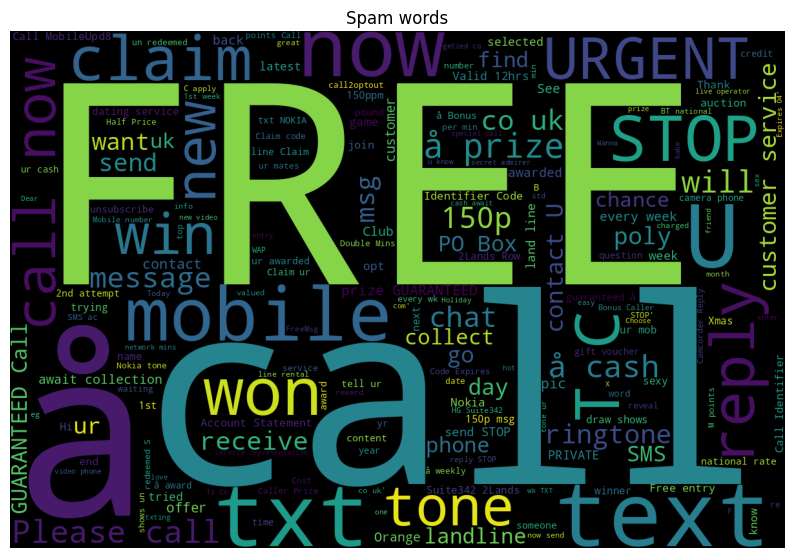

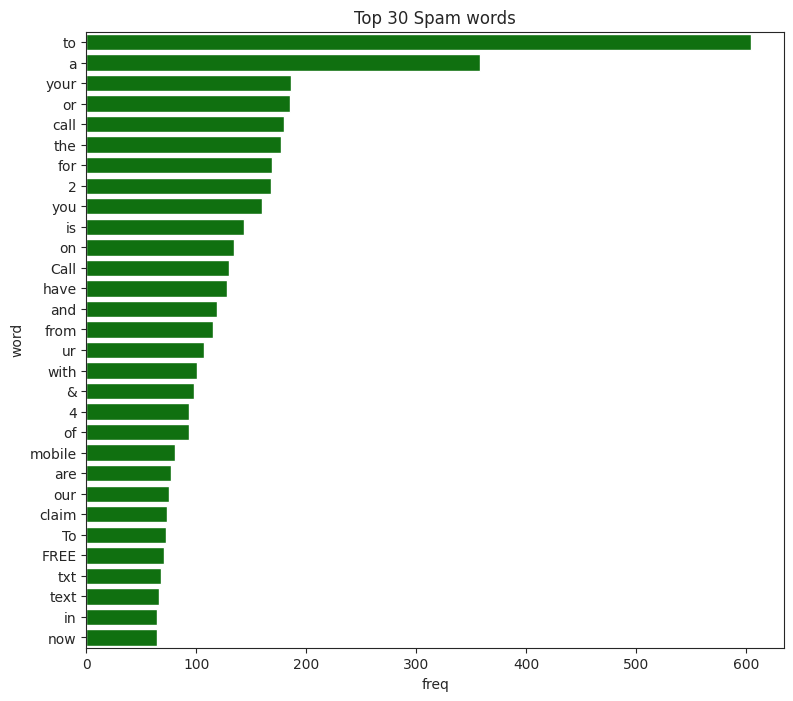

In [ ]:
# Generate a word cloud
tokens = str(list(df[df['v1'] == 'spam']['v2'])).split()
pos_words = " ".join(tokens)
wc = WordCloud(height=800, width=1200).generate(pos_words)
plt.figure(figsize=(10, 9))
plt.imshow(wc)
plt.title("Spam words")
plt.axis("off")
plt.show()

# Count the frequency of each word
positive_words_frequency = Counter(tokens)
ps_f = positive_words_frequency.most_common(30)
data = pd.DataFrame(ps_f, columns=['word', 'freq']).sort_values('freq', ascending=False)
plt.figure(figsize=(9, 8))
sns.set_style("ticks")
sns.barplot(x="freq", y='word', data=data, color='g').set(title='Top 30 Spam words')
plt.show()

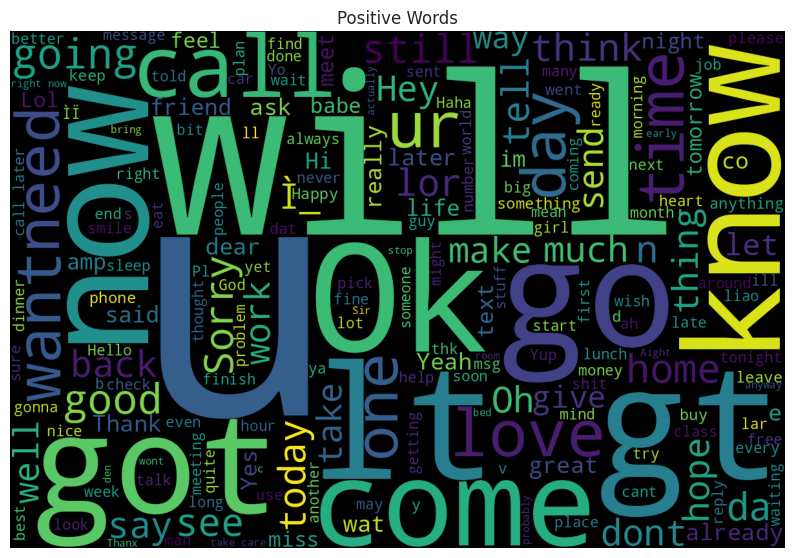

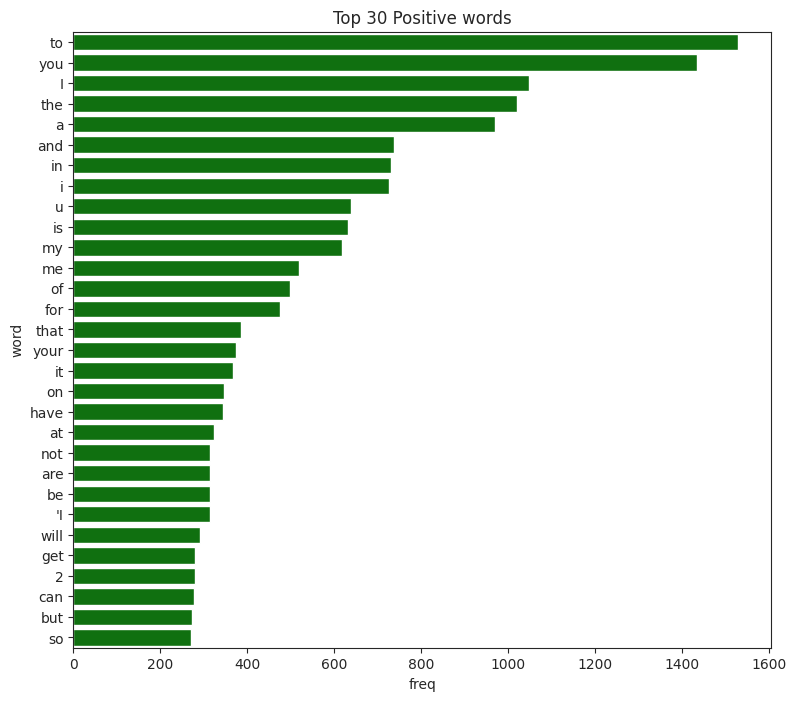

In [ ]:
# Generate a word cloud
tokens = str(list(df[df['v1'] == 'ham']['v2'])).split()
pos_words = " ".join(tokens)
wc = WordCloud(height=800, width=1200).generate(pos_words)
plt.figure(figsize=(10, 9))
plt.imshow(wc)
plt.title("Positive Words")
plt.axis("off")
plt.show()

# Count the frequency of each word
positive_words_frequency = Counter(tokens)
ps_f = positive_words_frequency.most_common(30)
data = pd.DataFrame(ps_f, columns=['word', 'freq']).sort_values('freq', ascending=False)
plt.figure(figsize=(9, 8))
sns.set_style("ticks")
sns.barplot(x="freq", y='word', data=data, color='g').set(title='Top 30 Positive words')
plt.show()

In [ ]:
print(df["v1"].unique())
df["v1"] = (df["v1"] == "spam").astype(int)
print(df["v1"].unique())
print(df["v1"].dtype)  # int64

['ham' 'spam']
[0 1]
int64


In [ ]:
print(df.head())

   v1                                                 v2
0   0  Go until jurong point, crazy.. Available only ...
1   0                      Ok lar... Joking wif u oni...
2   1  Free entry in 2 a wkly comp to win FA Cup fina...
3   0  U dun say so early hor... U c already then say...
4   0  Nah I don't think he goes to usf, he lives aro...


In [ ]:
# BERT tokenized sms
def get_bert_embeddings(reviews):
  embeddings = []

  for review in tqdm(reviews, desc="Processing reviews", unit="review"):
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
      outputs = model(**inputs)

    cls_embedding = outputs.last_hidden_state[:, 0, :]  # 提取 [CLS] token 的嵌入向量
    embeddings.append(cls_embedding.squeeze().cpu().numpy())  # 確保轉換為 numpy array

  # 將列表轉換為 numpy array
  return np.array(embeddings)

# 使用修改後的函數
sms = df.v2
X_bert = get_bert_embeddings(sms)

Processing reviews: 100%|██████████| 5572/5572 [01:11<00:00, 77.78review/s] 


In [ ]:
# Pickle file
'''
<class 'numpy.ndarray'>
[[-0.15130675 -0.3229208   0.18984704 ... -0.5061798   0.63785595
   0.5440407 ]
 [-0.12379772  0.3435445  -0.00094383 ... -0.29435182  0.31472534
   0.56761503]
 [-0.5030959  -0.28293788  0.5747769  ... -0.20974267  0.28015432
   0.6524718 ]
 ...
 [-0.04637506  0.07157683 -0.28113145 ... -0.4460993   0.69265234
   0.49261078]
 [ 0.2887204   0.2153074  -0.35321608 ... -0.3058895   0.02576492
   0.0527986 ]
 [-0.62542427  0.01535286  0.06213325 ... -0.3153857   0.53805584
   0.7060129 ]]

len = 5572
data[0].shape = (768,)
'''

In [ ]:
import pickle

# 儲存 embedding 資料
if input('是否儲存pickle檔案 (y/n)')=='y':
  with open('/content/drive/MyDrive/X_bert_embeddings_spam.pkl', 'wb') as f:
    pickle.dump(X_bert, f)
  print("File saved")

是否儲存pickle檔案 (y/n)y
File saved


In [ ]:
# 載入 embedding 資料
'''
with open('X_bert_embeddings_spam.pkl', 'rb') as f:
    X_bert_loaded = pickle.load(f)
print(np.array(X_bert_loaded).shape)  # 應該和原來的 X_bert 相同
'''

In [ ]:
lb = LabelEncoder()
y = lb.fit_transform(df.v1)

In [ ]:
# 切分訓練集和測試集
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, y, test_size=0.15, random_state=42, stratify=y)

In [ ]:
print(X_train_bert.shape)
print(X_test_bert.shape)

(4736, 768)
(836, 768)


# Models

In [ ]:
from sklearn.svm            import SVC
from sklearn.naive_bayes    import GaussianNB
from sklearn.linear_model   import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree           import DecisionTreeClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import RandomForestClassifier



models = {
  'lr': LogisticRegression(),
  'lr_l1': LogisticRegression(penalty='l1', solver='liblinear'),
  'lr_l2': LogisticRegression(penalty='l2'),
  'rf': RandomForestClassifier(),
  'dt': DecisionTreeClassifier(),
  'svm': SVC(probability=True),
  'gs': GaussianNB(),
  'knn': KNeighborsClassifier(),
  'mlp': MLPClassifier(),
  'perceptron': Perceptron()
}

In [ ]:
# 訓練多個模型並評估其表現
def fit_predict(models, X_train, y_train, X_test, y_test):
  y_pred = []
  models_name = []

  for model_name, model_obj in models.items():
    # 記錄開始時間
    start_time = time.time()
    print(f"Training {model_name}...")

    # 訓練模型
    model_obj.fit(X_train, y_train)

    # 記錄結束時間
    end_time = time.time()
    elapsed_time = end_time - start_time  # 計算訓練時間
    print(f"Done.\nTraining time: {elapsed_time:.4f} seconds\n")

    # 預測測試數據
    y_pred.append(model_obj.predict(X_test))
    models_name.append(model_name)

  return y_pred, models_name

# Train

In [ ]:
y_pred_bert, models_name_bert = fit_predict(models, X_train_bert, y_train_bert, X_test_bert, y_test_bert)

Training lr...
Done.
Training time: 0.2311 seconds

Training lr_l1...
Done.
Training time: 0.4851 seconds

Training lr_l2...
Done.
Training time: 0.2058 seconds

Training rf...
Done.
Training time: 15.0015 seconds

Training dt...
Done.
Training time: 13.4954 seconds

Training svm...
Done.
Training time: 3.5413 seconds

Training gs...
Done.
Training time: 0.0179 seconds

Training knn...
Done.
Training time: 0.0051 seconds

Training mlp...
Done.
Training time: 7.4582 seconds

Training perceptron...
Done.
Training time: 0.1141 seconds



# Model's Score

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def get_score(y_pred, y_test):
  score = [accuracy_score(y_test, y) for y in y_pred]
  return score

<ipython-input-22-c957f71cb489>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='models', y='score', data=md_scores_sorted, palette='rocket')


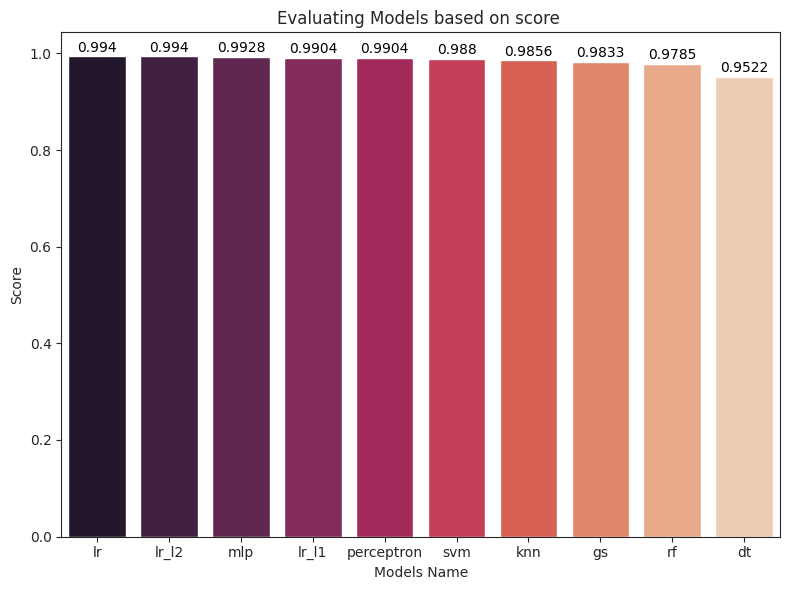

In [ ]:
# 計算模型的得分
score = get_score(y_pred_bert, y_test_bert)

# 創建包含模型名稱和分數的 DataFrame
md_scores = pd.DataFrame({'models': models_name_bert, 'score': score})

md_scores_sorted = md_scores.sort_values(by='score', ascending=False)

# 繪製柱狀圖，並將分數顯示在每個柱上
plt.figure(figsize=(8, 6))
bars = sns.barplot(x='models', y='score', data=md_scores_sorted, palette='rocket')

# 在每個柱上顯示分數（從已排序的 DataFrame 中讀取分數資料）
for bar, value in zip(bars.patches, md_scores_sorted['score']):
  bars.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, round(value, 4), ha='center', color='black', fontsize=10)

plt.title('Evaluating Models based on score ')
plt.xlabel('Models Name')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

In [ ]:
# 定義繪製混淆矩陣和分類報告的函數
def plot_evaluation_metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
  plt.title('Confusion Matrix')
  plt.show()
  print("Classification Report:")
  print(classification_report(y_test, y_pred))

Evaluating Model: lr


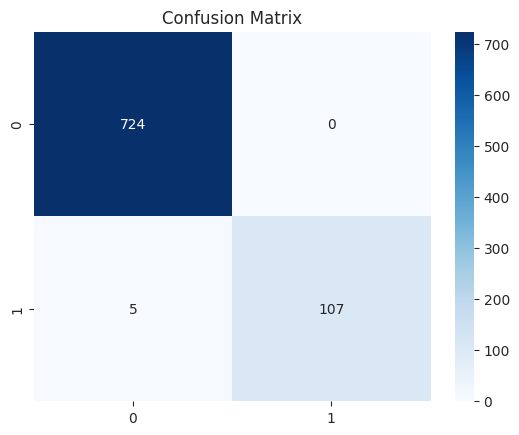

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       724
           1       1.00      0.96      0.98       112

    accuracy                           0.99       836
   macro avg       1.00      0.98      0.99       836
weighted avg       0.99      0.99      0.99       836

Evaluating Model: lr_l1


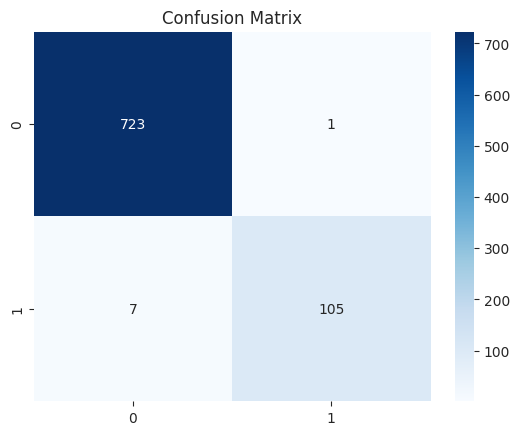

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       724
           1       0.99      0.94      0.96       112

    accuracy                           0.99       836
   macro avg       0.99      0.97      0.98       836
weighted avg       0.99      0.99      0.99       836

Evaluating Model: lr_l2


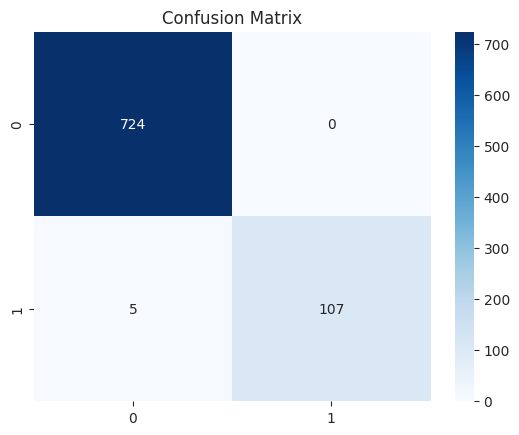

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       724
           1       1.00      0.96      0.98       112

    accuracy                           0.99       836
   macro avg       1.00      0.98      0.99       836
weighted avg       0.99      0.99      0.99       836

Evaluating Model: rf


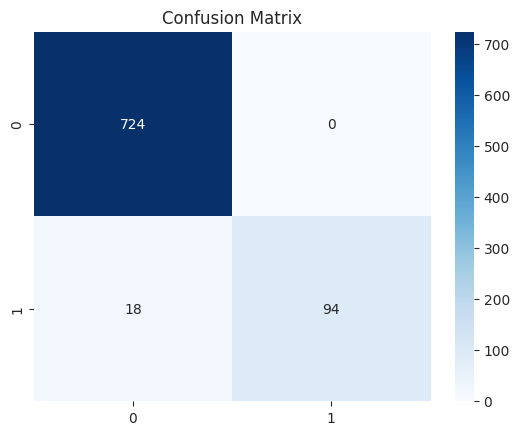

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       724
           1       1.00      0.84      0.91       112

    accuracy                           0.98       836
   macro avg       0.99      0.92      0.95       836
weighted avg       0.98      0.98      0.98       836

Evaluating Model: dt


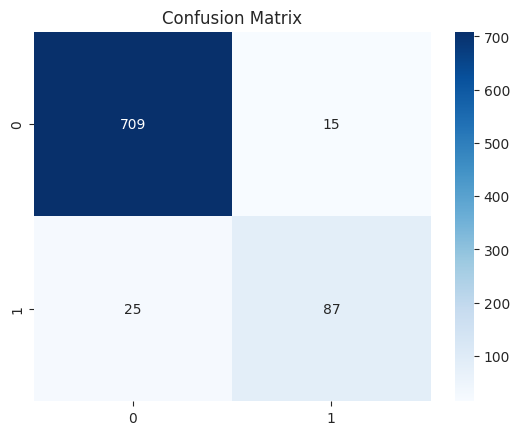

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       724
           1       0.85      0.78      0.81       112

    accuracy                           0.95       836
   macro avg       0.91      0.88      0.89       836
weighted avg       0.95      0.95      0.95       836

Evaluating Model: svm


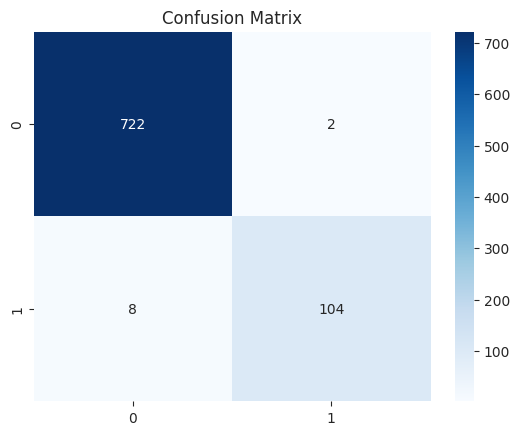

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       724
           1       0.98      0.93      0.95       112

    accuracy                           0.99       836
   macro avg       0.99      0.96      0.97       836
weighted avg       0.99      0.99      0.99       836

Evaluating Model: gs


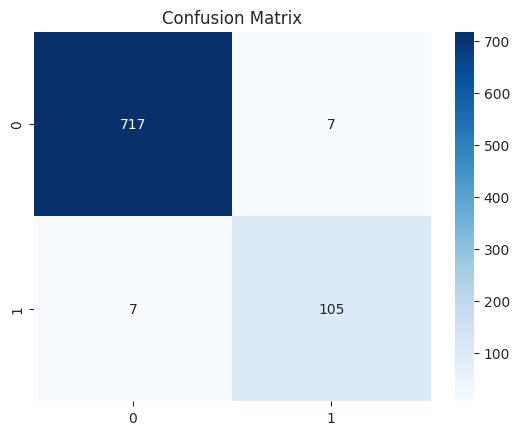

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.94      0.94      0.94       112

    accuracy                           0.98       836
   macro avg       0.96      0.96      0.96       836
weighted avg       0.98      0.98      0.98       836

Evaluating Model: knn


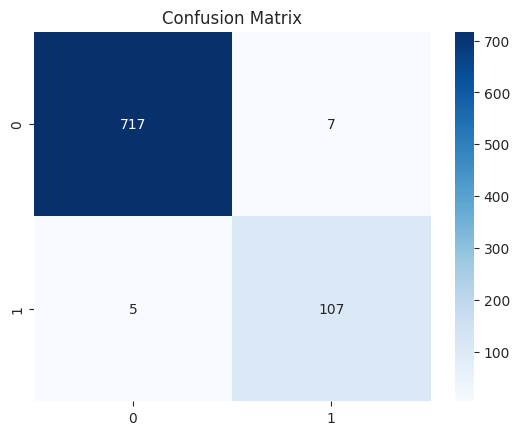

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.94      0.96      0.95       112

    accuracy                           0.99       836
   macro avg       0.97      0.97      0.97       836
weighted avg       0.99      0.99      0.99       836

Evaluating Model: mlp


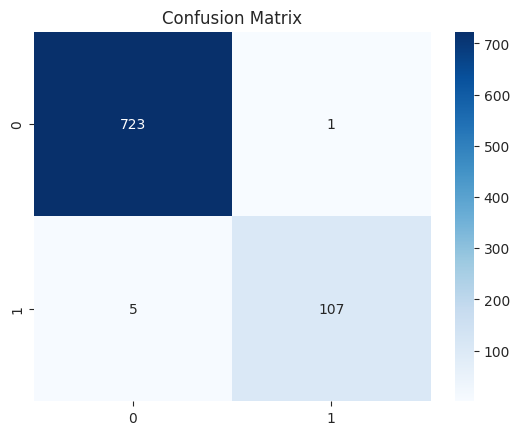

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       724
           1       0.99      0.96      0.97       112

    accuracy                           0.99       836
   macro avg       0.99      0.98      0.98       836
weighted avg       0.99      0.99      0.99       836

Evaluating Model: perceptron


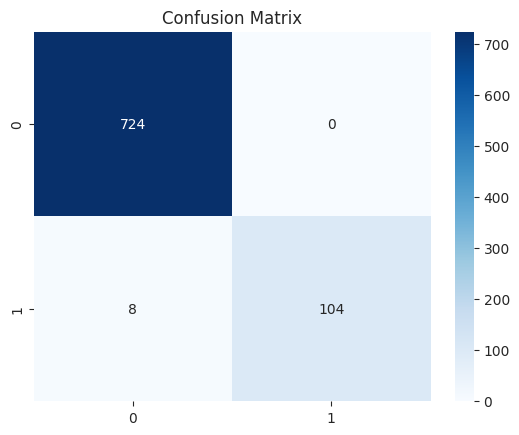

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       724
           1       1.00      0.93      0.96       112

    accuracy                           0.99       836
   macro avg       0.99      0.96      0.98       836
weighted avg       0.99      0.99      0.99       836



In [ ]:
for model_name, model_obj in models.items():
  print(f"Evaluating Model: {model_name}")
  plot_evaluation_metrics(model_obj, X_test_bert, y_test_bert)